In [1]:
import os
import sys
sys.path.append("..")
import time
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.Spectroscopy import Spectrum
from LowLevelModules.GeneralFunctions import LivePlot2D, prettify_2d_plot
from LowLevelModules.LightField import LightField

# Initialize LightField --> make sure LF is closed before starting this initialization
LFauto = LightField() # takes about 1 minute

Lightfield startup and setup OK


In [2]:
from LowLevelModules.GeneralFunctions import *
import pandas as pd
from LowLevelModules.Spectroscopy import Spectrum

In [25]:
import ipywidgets as widgets
from IPython.display import display

etaloning_choice = widgets.Checkbox(value=False, description='Remove CCD etaloning')
x_axis_choice = widgets.RadioButtons(options=['Wavelength (nm)', 'Energy (eV)'],
                                     value='Wavelength (nm)',
                                     description='X axis unit:')
base_dir_widg = widgets.Text(value=r'Z:\Projects\Diamond NV centers\NV spectrometer\20200129',
                            description='Directory: ',
                            disabled=False)
base_name_widg = widgets.Text(value='AutomationTest',
                              description='Filename: ',
                              disabled=False)
acq_time_widg = widgets.IntSlider(value=10,
                                  min=0,
                                  max=60,
                                  step=1,
                                  description='Acq. time:',
                                  disabled=False,
                                  continuous_update=False,
                                  orientation='horizontal',
                                  readout=True,
                                  readout_format='d'
                            )
# v_range_widg = widgets.IntRangeSlider(value=[-5, 5],
#                                       min=-20,
#                                       max=20,
#                                       step=1,
#                                       description='V range:',
#                                       disabled=False,
#                                       continuous_update=False,
#                                       orientation='horizontal',
#                                       readout=True,
#                                       readout_format='d')

display(etaloning_choice)
display(x_axis_choice)
display(base_dir_widg)
display(base_name_widg)
display(acq_time_widg)
# display(v_range_widg)

Checkbox(value=False, description='Remove CCD etaloning')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

Text(value='Z:\\Projects\\Diamond NV centers\\NV spectrometer\\20200129', description='Directory: ')

Text(value='AutomationTest', description='Filename: ')

IntSlider(value=10, continuous_update=False, description='Acq. time:', max=60)

In [28]:
wdir = base_dir_widg.value
base_name = base_name_widg.value
scan_step_size = (v_range_widg.value[1] - v_range_widg.value[0]) / 20
# V_range = np.arange(v_range_widg.value[0], v_range_widg.value[1] + scan_step_size, scan_step_size)
acq_time = acq_time_widg.value
save_data = True

# Enable the voltage source output
# keithley.enable_source()
#deal with LightField settings
LFauto.set_acquisition_time(acq_time)
LFauto.set_path(wdir)
LFauto.set_filename(base_name)
LFauto.set_filename_increment(True)

In [18]:
LFauto.acquire()

In [19]:
data_ref = LFauto.load_acquired_data(wdir, "Dummy test 34")

<IPython.core.display.Javascript object>


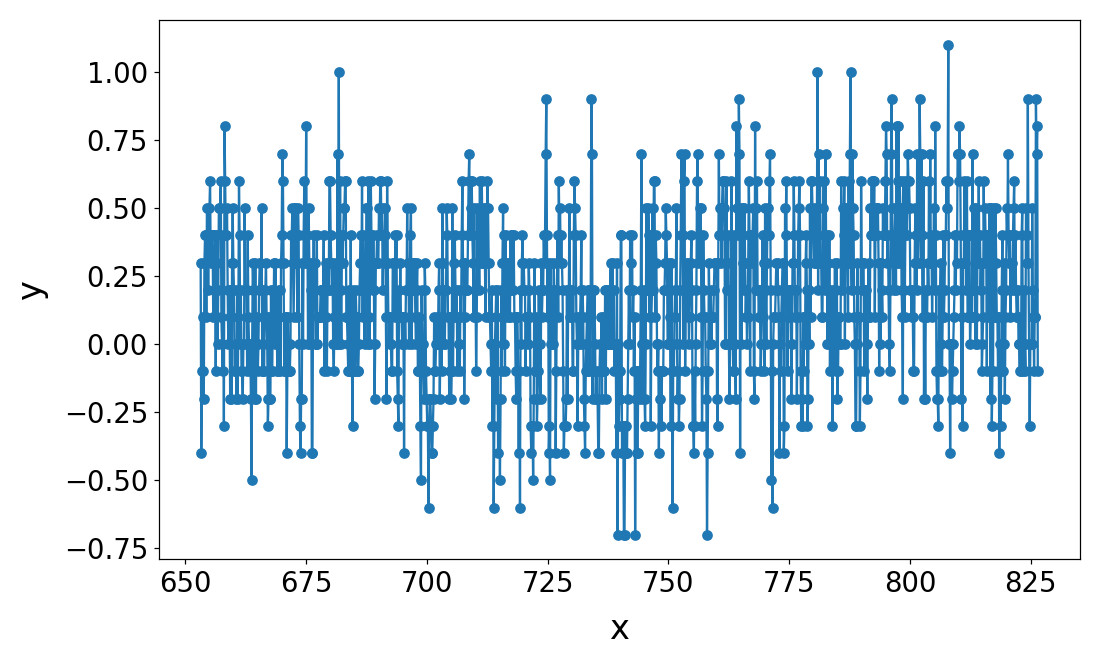

In [20]:
lp = LivePlot(subpl=1)
lp.plot_live(data_ref.x,data_ref.y)

<IPython.core.display.Javascript object>


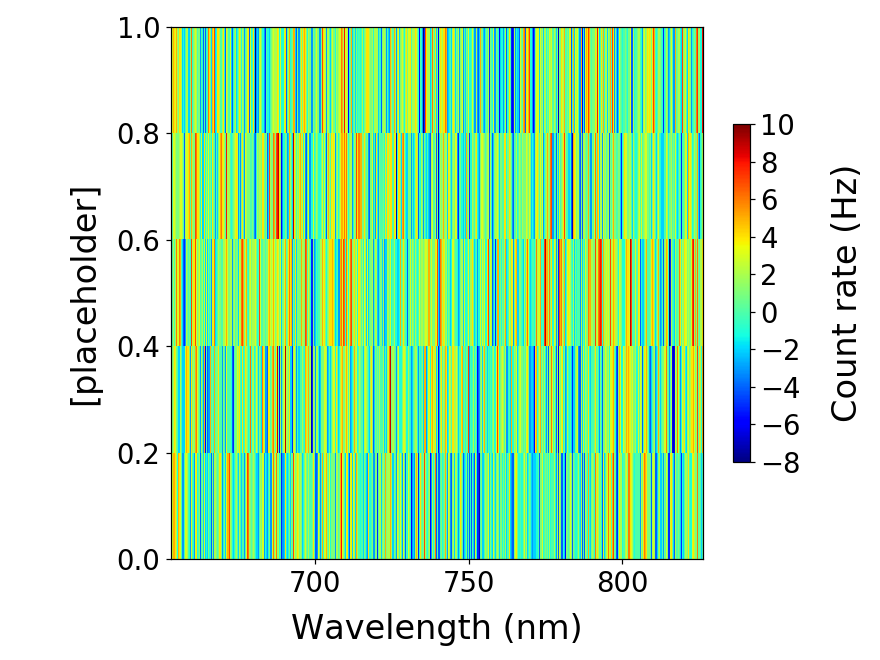

Z:\Projects\Diamond NV centers\NV spectrometer\20200129\auto test_Vscan.png


In [33]:
# Acquire in LightField
# continuously take measurements
scan_list = np.linspace(0,1,5)
LFauto.set_filename_increment(False)
if not "ref_spect_noV.spe" in os.listdir(wdir):
    LFauto.set_filename("ref_spect_noV")    
    LFauto.acquire()

data_ref = LFauto.load_acquired_data(wdir, "ref_spect_noV")
xdata = data_ref.x
ydata = scan_list
zdata = np.zeros((len(ydata), len(xdata)))

lp = LivePlot2D(xdata, ydata, zdata, 8, 6)
prettify_2d_plot(lp.ax, lp.cb, x_axis_choice.value, '[placeholder]', 'Count rate (Hz)')

for i, v in enumerate(scan_list):
    try: 
        # change the voltage
#         keithley.ramp_to_voltage(v)
#         time.sleep()  # delay in seconds
#         curr_curr = keithley.current
        # update file name to save data
        LFauto.set_filename(base_name + str(v) + "AU")
        # Acquire image
        LFauto.acquire()
        data = LFauto.load_acquired_data(wdir, base_name + str(v) + "AU")
        data.remove_cosmic_ray(4)
        if etaloning_choice.value:
            data.remove_etaloning(0.28, 0.46, 0.02, plotplot=False)
    #     if x_axis_choice.value == 'Energy (eV)':
    #         data.x = 1241/data.x
    #         data.x = data.x[::-1]
    #         data.y = data.y[::-1]
    #     if normalize_choice.value:
    #         data.y = data.y / np.max(data.y) + i*0.5

        zdata[i,:] = data.y
        lp.plot_live(zdata)  
    except KeyboardInterrupt:
        break
        
# keithley.ramp_to_voltage(0)
# keithley.disable_source()

plt.show()
if save_data:
    lp.fig.savefig(wdir + '\\' + base_name + '_Vscan.png', format='png', bbox_inches='tight')
    np.savetxt(wdir + '\\' + base_name + '_Vscan_x.txt', xdata)
    np.savetxt(wdir + '\\' + base_name + '_Vscan_y.txt', ydata)
    np.savetxt(wdir + '\\' + base_name + '_Vscan_z.txt', zdata)
    print(wdir + '\\' + base_name + '_Vscan.png')
    